## 在Github 找到有人建過 pytorch 版的 Scaden
###### https://github.com/poseidonchan/TAPE/blob/main/Experiments/pytorch_scaden_PBMConly.ipynb

In [1]:
!nvidia-smi

Mon Aug 29 04:37:06 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.56       Driver Version: 418.56       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:5E:00.0 Off |                  N/A |
|  0%   43C    P2    62W / 280W |    823MiB / 11178MiB |     12%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  Off  | 00000000:AF:00.0 Off |                  N/A |
|  0%   33C    P5    21W / 280W |      0MiB / 11178MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
        

In [2]:
from tqdm import tqdm
import torch
import random
import numpy as np
import pandas as pd
import collections
import anndata
from anndata import read_h5ad
import torch.utils.data as Data
import torch.nn.functional as F
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import torch.nn as nn
import matplotlib.pyplot as plt
import scanpy as sc
from torchsummary import summary
from scipy.stats import pearsonr
from sklearn import preprocessing

In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
adata = read_h5ad('../0819_simulate_harmony_10p_400cell.h5ad')
adata

AnnData object with n_obs × n_vars = 40000 × 1971
    obs: 'CD141+DC', 'CD4/CD8-C1-CCR7', 'CD4/CD8-C2-MKI67', 'CD8-C7-KLRD1', 'CD8-C9-SLC4A10', 'Central memory T cells', 'Circulating NK', 'Conventional dendritic cells(CD1C DC)', 'Cytotoxicity CD8T', 'DC-C4-LAMP3', 'Effector memory T cells', 'Exhausted CD8+ T (Tex) cells', 'ILCs', 'Liver-resident NK (lrNK) cell', 'Lymphoid-B', 'M-C4-GPX3', 'M1', 'Mast', 'Mono', 'Myeloid-derived suppressor cells', 'NK', 'TAM-like', 'Th0', 'Th1', 'Treg', 'donor'

In [5]:
collections.Counter(adata.obs['donor'])

Counter({'D20171109': 8000,
         'D20171215': 8000,
         'D20180108': 8000,
         'D20180110': 8000,
         'D20180116': 8000})

In [6]:
print(adata.X.shape)
adata.X[0,0:20]

(40000, 1971)


array([0.45434144, 0.45036224, 0.4533302 , 0.45088944, 0.4573363 ,
       0.4508126 , 0.44969353, 0.4472141 , 0.46503764, 0.45201582,
       0.451823  , 0.44952905, 0.4523986 , 0.01986132, 0.45055664,
       0.45078883, 0.88488394, 0.46264482, 0.44970718, 0.43994436],
      dtype=float32)

## Scaden

In [7]:
class MLP_drop_m256(nn.Module):
    def __init__(self, gene_size, unit):
        super(MLP_drop_m256, self).__init__()
        self.gene_size = gene_size
        self.unit = unit
        
        self.D1 = nn.Sequential(
            nn.Linear(self.gene_size, 256),
            nn.Dropout(p=0),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.Dropout(p=0.5),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.Dropout(p=0.5),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.Dropout(p=0.5),
            nn.ReLU(),
            nn.Linear(32, self.unit),
            nn.Softmax(dim=1)
        )

    def forward(self, inputs):
        out = self.D1(inputs)
        return out

In [8]:
class MLP_drop_m512(nn.Module):
    def __init__(self, gene_size, unit):
        super(MLP_drop_m512, self).__init__()
        self.gene_size = gene_size
        self.unit = unit
        
        self.D1 = nn.Sequential(
            nn.Linear(self.gene_size, 512),
            nn.Dropout(p=0),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.Dropout(p=0.5),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.Dropout(p=0.5),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.Dropout(p=0.5),
            nn.ReLU(),
            nn.Linear(64, self.unit),
            nn.Softmax(dim=1)
        )

    def forward(self, inputs):
        out = self.D1(inputs)
        return out

In [9]:
class MLP_drop_m1024(nn.Module):
    def __init__(self, gene_size, unit):
        super(MLP_drop_m1024, self).__init__()
        self.gene_size = gene_size
        self.unit = unit
        
        self.D1 = nn.Sequential(
            nn.Linear(self.gene_size, 1024),
            nn.Dropout(p=0),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.Dropout(p=0.5),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.Dropout(p=0.5),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.Dropout(p=0.5),
            nn.ReLU(),
            nn.Linear(128, self.unit),
            nn.Softmax(dim=1)
        )
    def forward(self, inputs):
        out = self.D1(inputs)
        return out

In [10]:
class MLP_batch(nn.Module):
    def __init__(self, gene_size, unit):
        super(MLP_batch, self).__init__()
        self.gene_size = gene_size
        self.unit = unit
        
        self.D1 = nn.Sequential(
            nn.Linear(self.gene_size, 256),
            nn.Dropout(p=0),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.Dropout(p=0.5),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.Dropout(p=0.5),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.Dropout(p=0.5),
            nn.ReLU(),
            nn.Linear(32, self.unit),
            nn.Softmax(dim=1)
        )
        self.D2 = nn.Sequential(
            nn.Linear(self.gene_size, 512),
            nn.Dropout(p=0),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.Dropout(p=0.5),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.Dropout(p=0.5),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.Dropout(p=0.5),
            nn.ReLU(),
            nn.Linear(64, self.unit),
            nn.Softmax(dim=1)
        )
        self.D3 = nn.Sequential(
            nn.Linear(self.gene_size, 1024),
            nn.Dropout(p=0),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.Dropout(p=0.5),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.Dropout(p=0.5),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.Dropout(p=0.5),
            nn.ReLU(),
            nn.Linear(128, self.unit),
            nn.Softmax(dim=1)
        )
    def forward(self, inputs):
        out1 = self.D1(inputs)
        out2 = self.D2(inputs)
        out3 = self.D3(inputs)
        
        out = (out1+out2+out3)/3
        return out

## Preprocess train, validation

### Training harmony

In [11]:
date = "0821"

In [12]:
dropout_rate = "050_050_050"
l2_weight = 0.005

In [ ]:
train_list = 'D20171109'

In [ ]:
train_list = 'D20171215'

In [ ]:
train_list = 'D20180108'

In [ ]:
train_list = 'D20180110'

In [ ]:
train_list = 'D20180116'

In [13]:
train_list = 'D20171109 D20180108 D20180110 D20180116'
val_list = 'D20171215'

# Convert training datasets list
if train_list== '':
    train_list = []
else:
    train_list = train_list.split()
print("Training on: " + str(train_list))

Training on: ['D20171109', 'D20180108', 'D20180110', 'D20180116']


In [14]:
train_data = adata

# 取出trian dataset: Subset dataset
if len(train_list) > 0:
    all_ds = collections.Counter(adata.obs['donor'])
    for i in all_ds:
        if i not in train_list:
            train_data = train_data[train_data.obs['donor'] != i].copy()

collections.Counter(train_data.obs['donor'])

Counter({'D20171109': 8000,
         'D20180108': 8000,
         'D20180110': 8000,
         'D20180116': 8000})

### all datasets

In [15]:
#取出val_dataset: Subset dataset
val_data = adata[adata.obs['donor'] == val_list]

In [16]:
#將 train_data 分開
#sample x gene
t_exp = train_data.X
t_obs = train_data.obs.drop('donor', axis=1)
celltype = list(t_obs.columns)

v_exp = val_data.X
v_obs = val_data.obs.drop('donor', axis=1)

#x_train, x_test, y_train, y_test = train_test_split(t_exp, t_obs, test_size = 0.2)

train = torch.tensor(t_exp, dtype=torch.float32)
train_label = torch.tensor(np.array(t_obs), dtype=torch.float32)

test = torch.tensor(v_exp, dtype=torch.float32)
test_label = torch.tensor(np.array(v_obs), dtype=torch.float32)

### one datasets

In [ ]:
#將 train_data 分開
#sample x gene
t_exp = train_data.X

t_obs = train_data.obs.drop('donor', axis=1)
celltype = list(t_obs.columns)

x_train, x_test, y_train, y_test = train_test_split(t_exp, t_obs, test_size = 0.2, random_state=2)

train = torch.tensor(x_train, dtype=torch.float32)
train_label = torch.tensor(np.array(y_train), dtype=torch.float32)
test = torch.tensor(x_test, dtype=torch.float32)
test_label = torch.tensor(np.array(y_test), dtype=torch.float32)

# M256

In [32]:
mlp = MLP_drop_m256(t_exp.shape[1], len(celltype)).to(device)

loss_fn = nn.L1Loss()
optimizer = torch.optim.Adam(mlp.parameters(),lr=0.0001)

#Load data
train_dataset = Data.TensorDataset(train, train_label)
train_dataset = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataset = Data.TensorDataset(test, test_label)
test_dataset = torch.utils.data.DataLoader(test_dataset, batch_size=64)

#print(mlp)

In [33]:
train_loss_list = []
t_loss =[]
val_loss_list = []
v_loss = []

cor = []
cor_list = []
val_cor = []
val_cor_list = []

t_cor_list = []
v_cor_list = []
t_big_cor_list = []
v_big_cor_list = []

epochs = 50
big_type = [1,3,4,5,6,7,8,10,11,13,14,19,20,21,22,24]


In [34]:
#Train
for inte in range(epochs):
    mlp.train()
    print("--- Start training! ---", end="\r")
    print('      epoch: {}            '.format(inte+1))
    train_loss = 0
    val_loss = 0
    a = 0
    b = 0
    t_big = 0
    v_big = 0
    
    for n, D in enumerate(train_dataset):
        pred = mlp(D[0].float().cuda())
        MAE = loss_fn(pred, D[1].float().cuda())
        
        # compute penalty only for net.hidden parameters
        l2_penalty = l2_weight * sum([(p**2).sum() for p in mlp.parameters()])
        loss_with_penalty = MAE + l2_penalty
        
        optimizer.zero_grad()
        loss_with_penalty.backward()
        #MAE.backward()
        optimizer.step()
        
        train_loss += loss_with_penalty.item()
        #train_loss += MAE.item()
        t_loss.append(MAE.cpu().detach().numpy())
        
        t_cor = []
        t_big_cor = []
        for m in range(len(D[1])):
            corr, _ = pearsonr(D[1].cpu().detach().numpy()[m], pred.cpu().detach().numpy()[m])
            #挑出超過 5% 的種類
            corr_2, _ = pearsonr(D[1].cpu().detach().numpy()[m][big_type], pred.cpu().detach().numpy()[m][big_type])
            cor.append(corr)
            t_cor.append(corr)
            t_big_cor.append(corr_2)
            
        a = np.quantile(t_cor, 0.5).item()
        t_big = np.quantile(t_big_cor, 0.5).item()
        
    cor_list.append(cor)       
    t_cor_list.append(a)
    t_big_cor_list.append(t_big)
    train_loss_list.append(train_loss/len(train_dataset))    
    
#Validation    
    print("--- Now evaluation!!! ---",end="\r")
    mlp.eval()
    
    # Tell torch not to calculate gradients
    with torch.no_grad():
        for n, D in enumerate(test_dataset):
            pred = mlp(D[0].float().cuda())
            VAL = loss_fn(pred, D[1].float().cuda())
            # compute penalty only for net.hidden parameters
            l2_penalty = l2_weight * sum([(p**2).sum() for p in mlp.parameters()])
            loss_with_penalty = VAL + l2_penalty
            optimizer.zero_grad()
            optimizer.step()
            
            val_loss += loss_with_penalty.item()
            v_loss.append(VAL.cpu().detach().numpy())
            
            v_cor = []
            v_big_cor = []
            for m in range(len(D[1])):
                corr, _ = pearsonr(D[1].cpu().detach().numpy()[m], pred.cpu().detach().numpy()[m])
                #挑出超過 5% 的種類
                corr_2, _ = pearsonr(D[1].cpu().detach().numpy()[m][big_type], pred.cpu().detach().numpy()[m][big_type])
                val_cor.append(corr)
                v_cor.append(corr)
                v_big_cor.append(corr_2)
                
            b = np.quantile(v_cor,0.5).item()
            v_big = np.quantile(v_big_cor,0.5).item()
            
        val_cor_list.append(val_cor)
        v_cor_list.append(b)
        v_big_cor_list.append(v_big)
        val_loss_list.append(val_loss/len(test_dataset))
        
        
print(" ----- Finish!! ----- ", end="\r")

      epoch: 1            
      epoch: 2            
      epoch: 3            
      epoch: 4            
      epoch: 5            
      epoch: 6            
      epoch: 7            
      epoch: 8            
      epoch: 9            
      epoch: 10            
      epoch: 11            
      epoch: 12            
      epoch: 13            
      epoch: 14            
      epoch: 15            
      epoch: 16            
      epoch: 17            
      epoch: 18            
      epoch: 19            
      epoch: 20            
      epoch: 21            
      epoch: 22            
      epoch: 23            
      epoch: 24            
      epoch: 25            
      epoch: 26            
      epoch: 27            
      epoch: 28            
      epoch: 29            
      epoch: 30            
      epoch: 31            
      epoch: 32            
      epoch: 33            
      epoch: 34            
      epoch: 35            
      epoch: 36            
 

In [35]:
model = "m256"

In [36]:
torch.save(mlp.state_dict(), '../2.model/{}_model/{}_harmony_{}_{}_L2{}.pth'.format(date, date, model, dropout_rate, l2_weight))
torch.cuda.empty_cache()

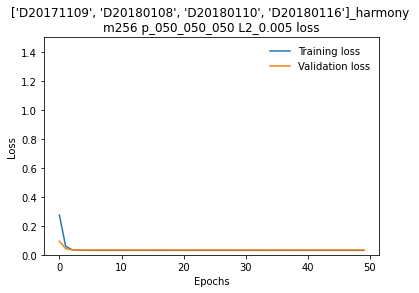

In [37]:
plt.title("{}_harmony \n{} p_{} L2_{} loss".format(train_list, model, dropout_rate, l2_weight))
plt.plot(train_loss_list,label='Training loss')
plt.plot(val_loss_list,label='Validation loss')
plt.ylim(0,1.5)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(frameon=False)
plt.savefig("../1.figure/{}_harmony/{}_harmony_{}_loss_p_{}_L2_{}.pdf".format(date, date, model, dropout_rate, l2_weight))

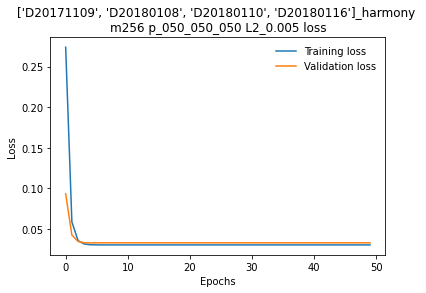

In [38]:
plt.title("{}_harmony \n{} p_{} L2_{} loss".format(train_list, model, dropout_rate, l2_weight))
plt.plot(train_loss_list,label='Training loss')
plt.plot(val_loss_list,label='Validation loss')
#plt.ylim(0,0.035)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(frameon=False)

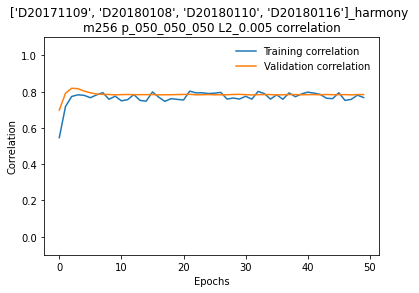

In [39]:
plt.title("{}_harmony \n{} p_{} L2_{} correlation".format(train_list, model, dropout_rate, l2_weight))
plt.plot(t_cor_list, label='Training correlation')
plt.plot(v_cor_list, label='Validation correlation')
plt.ylim(-0.1,1.1)
plt.xlabel('Epochs')
plt.ylabel('Correlation')
plt.legend(frameon=False)
plt.savefig("../1.figure/{}_harmony/{}_harmony_{}_{}_correlation_p_{}_L2_{}.pdf".format(date, date, model,
                                                                                train_list, dropout_rate, l2_weight))
plt.show()

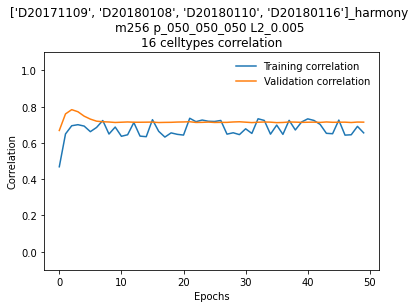

In [40]:
plt.title("{}_harmony \n{} p_{} L2_{} \n16 celltypes correlation".format(train_list, model, dropout_rate, l2_weight))
plt.plot(t_big_cor_list, label='Training correlation')
plt.plot(v_big_cor_list, label='Validation correlation')
plt.ylim(-0.1,1.1)
plt.xlabel('Epochs')
plt.ylabel('Correlation')
plt.legend(frameon=False)
plt.savefig("../1.figure/{}_harmony/{}_harmony_{}_{}_correlation_p_{}_L2_{}.pdf".format(date, date, model,
                                                                                train_list, dropout_rate, l2_weight))
plt.show()

In [41]:
rate = str(dropout_rate) +'_L2_'+ str(l2_weight)
r1 = np.quantile(train_loss_list,0.25)
r2 = np.quantile(cor_list,0.5)
r3 = np.quantile(val_cor_list,0.5)
r4 = np.quantile(t_big_cor_list,0.5)
r5 = np.quantile(v_big_cor_list,0.5)

data = {'Donor': [train_list],
        'Remove batch effect': 'harmony',
        'Model': [model],
        'Dropout rate': [rate],
        'Train loss (0.25)': [r1],
        'Train Correlation (0.5)': [r2],
        'Valid Correlation (0.5)': [r3],
        'Train Correlation (0.5) in 16 type': [r4],
        'Valid Correlation (0.5) in 16 type': [r5]
       }
df_1 = pd.DataFrame(data)

df_1

,Donor,Remove batch effect,Model,Dropout rate,Train loss (0.25),Train Correlation (0.5),Valid Correlation (0.5),Train Correlation (0.5) in 16 type,Valid Correlation (0.5) in 16 type
0,"[D20171109, D20180108, D20180110, D20180116]",harmony,m256,050_050_050_L2_0.005,0.030511,0.771111,0.783189,0.674895,0.714764


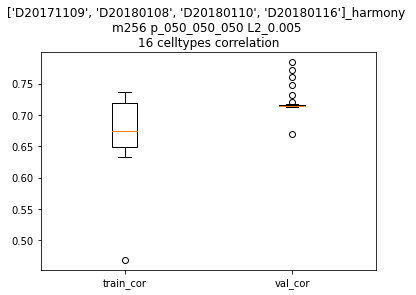

In [42]:
plt.title("{}_harmony \n{} p_{} L2_{} \n16 celltypes correlation".format(train_list, model, dropout_rate, l2_weight))
plt.boxplot([t_big_cor_list,v_big_cor_list])
plt.xticks([1,2], ["train_cor","val_cor"])
plt.show()

In [43]:
m256_t_cor = t_big_cor_list
m256_v_cor = v_big_cor_list

# M512

In [44]:
mlp = MLP_drop_m512(t_exp.shape[1], len(celltype)).to(device)

loss_fn = nn.L1Loss()
optimizer = torch.optim.Adam(mlp.parameters(),lr=0.0001)

#Load data
train_dataset = Data.TensorDataset(train, train_label)
train_dataset = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataset = Data.TensorDataset(test, test_label)
test_dataset = torch.utils.data.DataLoader(test_dataset, batch_size=64)

#print(mlp)

In [45]:
train_loss_list = []
t_loss =[]
val_loss_list = []
v_loss = []

cor = []
cor_list = []
val_cor = []
val_cor_list = []

t_cor_list = []
v_cor_list = []
t_big_cor_list = []
v_big_cor_list = []

epochs = 50
big_type = [1,3,4,5,6,7,8,10,11,13,14,19,20,21,22,24]


In [46]:
#Train
for inte in range(epochs):
    mlp.train()
    print("--- Start training! ---", end="\r")
    print('      epoch: {}            '.format(inte+1))
    train_loss = 0
    val_loss = 0
    a = 0
    b = 0
    t_big = 0
    v_big = 0
    
    for n, D in enumerate(train_dataset):
        pred = mlp(D[0].float().cuda())
        MAE = loss_fn(pred, D[1].float().cuda())
        
        # compute penalty only for net.hidden parameters
        l2_penalty = l2_weight * sum([(p**2).sum() for p in mlp.parameters()])
        loss_with_penalty = MAE + l2_penalty
        
        optimizer.zero_grad()
        loss_with_penalty.backward()
        #MAE.backward()
        optimizer.step()
        
        train_loss += loss_with_penalty.item()
        #train_loss += MAE.item()
        t_loss.append(MAE.cpu().detach().numpy())
        
        t_cor = []
        t_big_cor = []
        for m in range(len(D[1])):
            corr, _ = pearsonr(D[1].cpu().detach().numpy()[m], pred.cpu().detach().numpy()[m])
            #挑出超過 5% 的種類
            corr_2, _ = pearsonr(D[1].cpu().detach().numpy()[m][big_type], pred.cpu().detach().numpy()[m][big_type])
            cor.append(corr)
            t_cor.append(corr)
            t_big_cor.append(corr_2)
            
        a = np.quantile(t_cor, 0.5).item()
        t_big = np.quantile(t_big_cor, 0.5).item()
        
    cor_list.append(cor)       
    t_cor_list.append(a)
    t_big_cor_list.append(t_big)
    train_loss_list.append(train_loss/len(train_dataset))    
    
#Validation    
    print("--- Now evaluation!!! ---",end="\r")
    mlp.eval()
    
    # Tell torch not to calculate gradients
    with torch.no_grad():
        for n, D in enumerate(test_dataset):
            pred = mlp(D[0].float().cuda())
            VAL = loss_fn(pred, D[1].float().cuda())
            # compute penalty only for net.hidden parameters
            l2_penalty = l2_weight * sum([(p**2).sum() for p in mlp.parameters()])
            loss_with_penalty = VAL + l2_penalty
            optimizer.zero_grad()
            optimizer.step()
            
            val_loss += loss_with_penalty.item()
            v_loss.append(VAL.cpu().detach().numpy())
            
            v_cor = []
            v_big_cor = []
            for m in range(len(D[1])):
                corr, _ = pearsonr(D[1].cpu().detach().numpy()[m], pred.cpu().detach().numpy()[m])
                #挑出超過 5% 的種類
                corr_2, _ = pearsonr(D[1].cpu().detach().numpy()[m][big_type], pred.cpu().detach().numpy()[m][big_type])
                val_cor.append(corr)
                v_cor.append(corr)
                v_big_cor.append(corr_2)
                
            b = np.quantile(v_cor,0.5).item()
            v_big = np.quantile(v_big_cor,0.5).item()
            
        val_cor_list.append(val_cor)
        v_cor_list.append(b)
        v_big_cor_list.append(v_big)
        val_loss_list.append(val_loss/len(test_dataset))
        
        
print(" ----- Finish!! ----- ", end="\r")

      epoch: 1            
      epoch: 2            
      epoch: 3            
      epoch: 4            
      epoch: 5            
      epoch: 6            
      epoch: 7            
      epoch: 8            
      epoch: 9            
      epoch: 10            
      epoch: 11            
      epoch: 12            
      epoch: 13            
      epoch: 14            
      epoch: 15            
      epoch: 16            
      epoch: 17            
      epoch: 18            
      epoch: 19            
      epoch: 20            
      epoch: 21            
      epoch: 22            
      epoch: 23            
      epoch: 24            
      epoch: 25            
      epoch: 26            
      epoch: 27            
      epoch: 28            
      epoch: 29            
      epoch: 30            
      epoch: 31            
      epoch: 32            
      epoch: 33            
      epoch: 34            
      epoch: 35            
      epoch: 36            
 

In [47]:
model = "m512"

In [48]:
torch.save(mlp.state_dict(), '../2.model/{}_model/{}_harmony_{}_{}_L2{}.pth'.format(date, date, model, dropout_rate, l2_weight))
torch.cuda.empty_cache()

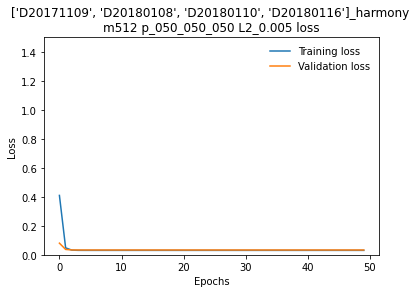

In [49]:
plt.title("{}_harmony \n{} p_{} L2_{} loss".format(train_list, model, dropout_rate, l2_weight))
plt.plot(train_loss_list,label='Training loss')
plt.plot(val_loss_list,label='Validation loss')
plt.ylim(0,1.5)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(frameon=False)
plt.savefig("../1.figure/{}_harmony/{}_harmony_{}_loss_p_{}_L2_{}.pdf".format(date, date, model, dropout_rate, l2_weight))

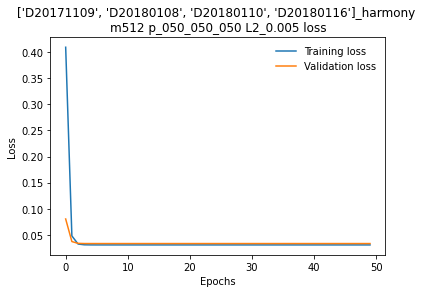

In [50]:
plt.title("{}_harmony \n{} p_{} L2_{} loss".format(train_list, model, dropout_rate, l2_weight))
plt.plot(train_loss_list,label='Training loss')
plt.plot(val_loss_list,label='Validation loss')
#plt.ylim(0,0.035)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(frameon=False)

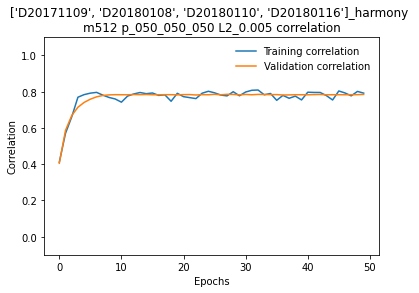

In [51]:
plt.title("{}_harmony \n{} p_{} L2_{} correlation".format(train_list, model, dropout_rate, l2_weight))
plt.plot(t_cor_list, label='Training correlation')
plt.plot(v_cor_list, label='Validation correlation')
plt.ylim(-0.1,1.1)
plt.xlabel('Epochs')
plt.ylabel('Correlation')
plt.legend(frameon=False)
plt.savefig("../1.figure/{}_harmony/{}_harmony_{}_{}_correlation_p_{}_L2_{}.pdf".format(date, date, model,
                                                                                train_list, dropout_rate, l2_weight))
plt.show()

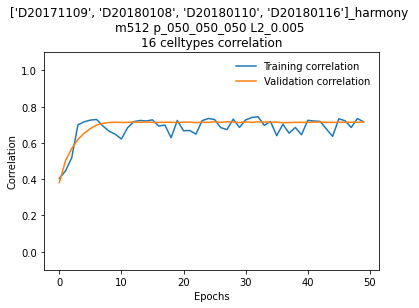

In [52]:
plt.title("{}_harmony \n{} p_{} L2_{} \n16 celltypes correlation".format(train_list, model, dropout_rate, l2_weight))
plt.plot(t_big_cor_list, label='Training correlation')
plt.plot(v_big_cor_list, label='Validation correlation')
plt.ylim(-0.1,1.1)
plt.xlabel('Epochs')
plt.ylabel('Correlation')
plt.legend(frameon=False)
plt.savefig("../1.figure/{}_harmony/{}_harmony_{}_{}_correlation_p_{}_L2_{}.pdf".format(date, date, model,
                                                                                train_list, dropout_rate, l2_weight))
plt.show()

In [53]:
rate = str(dropout_rate) +'_L2_'+ str(l2_weight)
r1 = np.quantile(train_loss_list,0.25)
r2 = np.quantile(cor_list,0.5)
r3 = np.quantile(val_cor_list,0.5)
r4 = np.quantile(t_big_cor_list,0.5)
r5 = np.quantile(v_big_cor_list,0.5)

data = {'Donor': [train_list],
        'Remove batch effect': 'harmony',
        'Model': [model],
        'Dropout rate': [rate],
        'Train loss (0.25)': [r1],
        'Train Correlation (0.5)': [r2],
        'Valid Correlation (0.5)': [r3],
        'Train Correlation (0.5) in 16 type': [r4],
        'Valid Correlation (0.5) in 16 type': [r5]
       }
df_2 = pd.DataFrame(data)

df_2

,Donor,Remove batch effect,Model,Dropout rate,Train loss (0.25),Train Correlation (0.5),Valid Correlation (0.5),Train Correlation (0.5) in 16 type,Valid Correlation (0.5) in 16 type
0,"[D20171109, D20180108, D20180110, D20180116]",harmony,m512,050_050_050_L2_0.005,0.030511,0.765763,0.780017,0.699334,0.713826


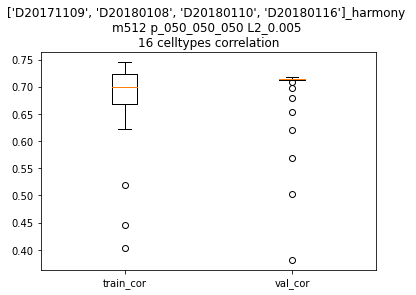

In [54]:
plt.title("{}_harmony \n{} p_{} L2_{} \n16 celltypes correlation".format(train_list, model, dropout_rate, l2_weight))
plt.boxplot([t_big_cor_list,v_big_cor_list])
plt.xticks([1,2], ["train_cor","val_cor"])
plt.show()

In [55]:
m512_t_cor = t_big_cor_list
m512_v_cor = v_big_cor_list

# M1024

In [56]:
mlp = MLP_drop_m1024(t_exp.shape[1], len(celltype)).to(device)

loss_fn = nn.L1Loss()
optimizer = torch.optim.Adam(mlp.parameters(),lr=0.0001)

#Load data
train_dataset = Data.TensorDataset(train, train_label)
train_dataset = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataset = Data.TensorDataset(test, test_label)
test_dataset = torch.utils.data.DataLoader(test_dataset, batch_size=64)

#print(mlp)

In [57]:
train_loss_list = []
t_loss =[]
val_loss_list = []
v_loss = []

cor = []
cor_list = []
val_cor = []
val_cor_list = []

t_cor_list = []
v_cor_list = []
t_big_cor_list = []
v_big_cor_list = []

epochs = 50
big_type = [1,3,4,5,6,7,8,10,11,13,14,19,20,21,22,24]


In [58]:
#Train
for inte in range(epochs):
    mlp.train()
    print("--- Start training! ---", end="\r")
    print('      epoch: {}            '.format(inte+1))
    train_loss = 0
    val_loss = 0
    a = 0
    b = 0
    t_big = 0
    v_big = 0
    
    for n, D in enumerate(train_dataset):
        pred = mlp(D[0].float().cuda())
        MAE = loss_fn(pred, D[1].float().cuda())
        
        # compute penalty only for net.hidden parameters
        l2_penalty = l2_weight * sum([(p**2).sum() for p in mlp.parameters()])
        loss_with_penalty = MAE + l2_penalty
        
        optimizer.zero_grad()
        loss_with_penalty.backward()
        #MAE.backward()
        optimizer.step()
        
        train_loss += loss_with_penalty.item()
        #train_loss += MAE.item()
        t_loss.append(MAE.cpu().detach().numpy())
        
        t_cor = []
        t_big_cor = []
        for m in range(len(D[1])):
            corr, _ = pearsonr(D[1].cpu().detach().numpy()[m], pred.cpu().detach().numpy()[m])
            #挑出超過 5% 的種類
            corr_2, _ = pearsonr(D[1].cpu().detach().numpy()[m][big_type], pred.cpu().detach().numpy()[m][big_type])
            cor.append(corr)
            t_cor.append(corr)
            t_big_cor.append(corr_2)
            
        a = np.quantile(t_cor, 0.5).item()
        t_big = np.quantile(t_big_cor, 0.5).item()
        
    cor_list.append(cor)       
    t_cor_list.append(a)
    t_big_cor_list.append(t_big)
    train_loss_list.append(train_loss/len(train_dataset))    
    
#Validation    
    print("--- Now evaluation!!! ---",end="\r")
    mlp.eval()
    
    # Tell torch not to calculate gradients
    with torch.no_grad():
        for n, D in enumerate(test_dataset):
            pred = mlp(D[0].float().cuda())
            VAL = loss_fn(pred, D[1].float().cuda())
            # compute penalty only for net.hidden parameters
            l2_penalty = l2_weight * sum([(p**2).sum() for p in mlp.parameters()])
            loss_with_penalty = VAL + l2_penalty
            optimizer.zero_grad()
            optimizer.step()
            
            val_loss += loss_with_penalty.item()
            v_loss.append(VAL.cpu().detach().numpy())
            
            v_cor = []
            v_big_cor = []
            for m in range(len(D[1])):
                corr, _ = pearsonr(D[1].cpu().detach().numpy()[m], pred.cpu().detach().numpy()[m])
                #挑出超過 5% 的種類
                corr_2, _ = pearsonr(D[1].cpu().detach().numpy()[m][big_type], pred.cpu().detach().numpy()[m][big_type])
                val_cor.append(corr)
                v_cor.append(corr)
                v_big_cor.append(corr_2)
                
            b = np.quantile(v_cor,0.5).item()
            v_big = np.quantile(v_big_cor,0.5).item()
            
        val_cor_list.append(val_cor)
        v_cor_list.append(b)
        v_big_cor_list.append(v_big)
        val_loss_list.append(val_loss/len(test_dataset))
        
        
print(" ----- Finish!! ----- ", end="\r")

      epoch: 1            
      epoch: 2            
      epoch: 3            
      epoch: 4            
      epoch: 5            
      epoch: 6            
      epoch: 7            
      epoch: 8            
      epoch: 9            
      epoch: 10            
      epoch: 11            
      epoch: 12            
      epoch: 13            
      epoch: 14            
      epoch: 15            
      epoch: 16            
      epoch: 17            
      epoch: 18            
      epoch: 19            
      epoch: 20            
      epoch: 21            
      epoch: 22            
      epoch: 23            
      epoch: 24            
      epoch: 25            
      epoch: 26            
      epoch: 27            
      epoch: 28            
      epoch: 29            
      epoch: 30            
      epoch: 31            
      epoch: 32            
      epoch: 33            
      epoch: 34            
      epoch: 35            
      epoch: 36            
 

In [59]:
model = "m1024"

In [60]:
torch.save(mlp.state_dict(), '../2.model/{}_model/{}_harmony_{}_{}_L2{}.pth'.format(date, date, model, dropout_rate, l2_weight))
torch.cuda.empty_cache()

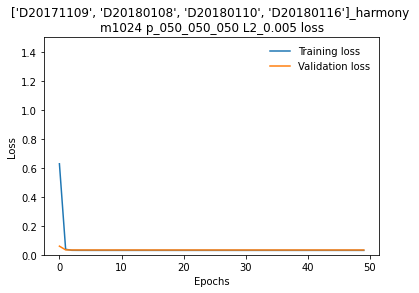

In [61]:
plt.title("{}_harmony \n{} p_{} L2_{} loss".format(train_list, model, dropout_rate, l2_weight))
plt.plot(train_loss_list,label='Training loss')
plt.plot(val_loss_list,label='Validation loss')
plt.ylim(0,1.5)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(frameon=False)
plt.savefig("../1.figure/{}_harmony/{}_harmony_{}_loss_p_{}_L2_{}.pdf".format(date, date, model, dropout_rate, l2_weight))

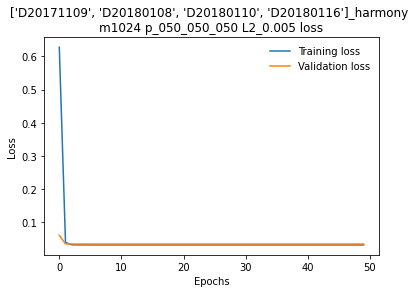

In [62]:
plt.title("{}_harmony \n{} p_{} L2_{} loss".format(train_list, model, dropout_rate, l2_weight))
plt.plot(train_loss_list,label='Training loss')
plt.plot(val_loss_list,label='Validation loss')
#plt.ylim(0,0.035)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(frameon=False)

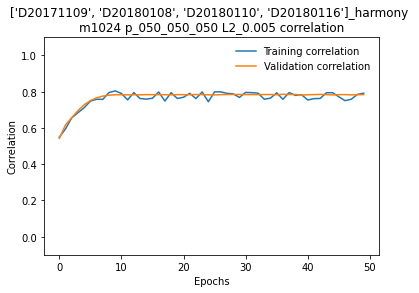

In [63]:
plt.title("{}_harmony \n{} p_{} L2_{} correlation".format(train_list, model, dropout_rate, l2_weight))
plt.plot(t_cor_list, label='Training correlation')
plt.plot(v_cor_list, label='Validation correlation')
plt.ylim(-0.1,1.1)
plt.xlabel('Epochs')
plt.ylabel('Correlation')
plt.legend(frameon=False)
plt.savefig("../1.figure/{}_harmony/{}_harmony_{}_{}_correlation_p_{}_L2_{}.pdf".format(date, date, model,
                                                                                train_list, dropout_rate, l2_weight))
plt.show()

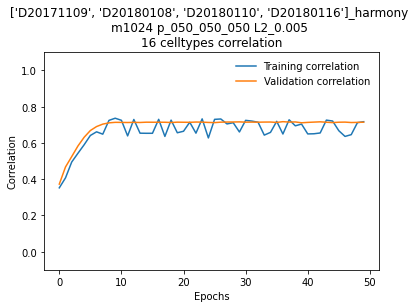

In [64]:
plt.title("{}_harmony \n{} p_{} L2_{} \n16 celltypes correlation".format(train_list, model, dropout_rate, l2_weight))
plt.plot(t_big_cor_list, label='Training correlation')
plt.plot(v_big_cor_list, label='Validation correlation')
plt.ylim(-0.1,1.1)
plt.xlabel('Epochs')
plt.ylabel('Correlation')
plt.legend(frameon=False)
plt.savefig("../1.figure/{}_harmony/{}_harmony_{}_{}_correlation_p_{}_L2_{}.pdf".format(date, date, model,
                                                                                train_list, dropout_rate, l2_weight))
plt.show()

In [65]:
rate = str(dropout_rate) +'_L2_'+ str(l2_weight)
r1 = np.quantile(train_loss_list,0.25)
r2 = np.quantile(cor_list,0.5)
r3 = np.quantile(val_cor_list,0.5)
r4 = np.quantile(t_big_cor_list,0.5)
r5 = np.quantile(v_big_cor_list,0.5)

data = {'Donor': [train_list],
        'Remove batch effect': 'harmony',
        'Model': [model],
        'Dropout rate': [rate],
        'Train loss (0.25)': [r1],
        'Train Correlation (0.5)': [r2],
        'Valid Correlation (0.5)': [r3],
        'Train Correlation (0.5) in 16 type': [r4],
        'Valid Correlation (0.5) in 16 type': [r5]
       }
df_3 = pd.DataFrame(data)

df_3

,Donor,Remove batch effect,Model,Dropout rate,Train loss (0.25),Train Correlation (0.5),Valid Correlation (0.5),Train Correlation (0.5) in 16 type,Valid Correlation (0.5) in 16 type
0,"[D20171109, D20180108, D20180110, D20180116]",harmony,m1024,050_050_050_L2_0.005,0.030511,0.762718,0.779875,0.663031,0.714294


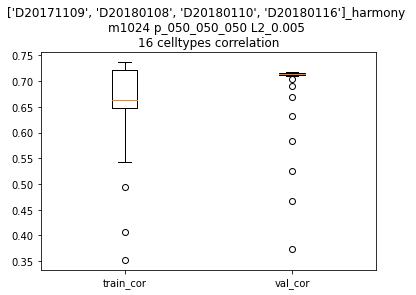

In [66]:
plt.title("{}_harmony \n{} p_{} L2_{} \n16 celltypes correlation".format(train_list, model, dropout_rate, l2_weight))
plt.boxplot([t_big_cor_list,v_big_cor_list])
plt.xticks([1,2], ["train_cor","val_cor"])
plt.show()

In [67]:
result_df = df_1.append([df_2,df_3], ignore_index=True)
result_df

,Donor,Remove batch effect,Model,Dropout rate,Train loss (0.25),Train Correlation (0.5),Valid Correlation (0.5),Train Correlation (0.5) in 16 type,Valid Correlation (0.5) in 16 type
0,"[D20171109, D20180108, D20180110, D20180116]",harmony,m256,050_050_050_L2_0.005,0.030511,0.771111,0.783189,0.674895,0.714764
1,"[D20171109, D20180108, D20180110, D20180116]",harmony,m512,050_050_050_L2_0.005,0.030511,0.765763,0.780017,0.699334,0.713826
2,"[D20171109, D20180108, D20180110, D20180116]",harmony,m1024,050_050_050_L2_0.005,0.030511,0.762718,0.779875,0.663031,0.714294


In [68]:
m1024_t_cor = t_big_cor_list
m1024_v_cor = v_big_cor_list

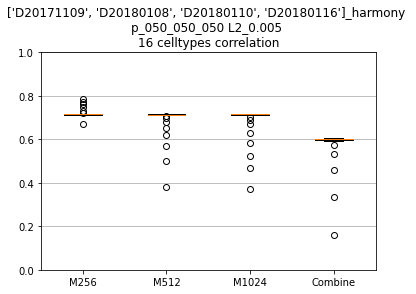

In [69]:
plt.title("{}_harmony \np_{} L2_{} \n16 celltypes correlation".
          format(train_list, dropout_rate, l2_weight))
plt.boxplot([m256_v_cor, m512_v_cor, m1024_v_cor, com_v_cor])
plt.xticks([1,2,3,4], ["M256","M512","M1024", "Combine"])
plt.ylim(0,1)
plt.grid(axis='y', which='major')
plt.show()

## Combine three submodel

In [17]:
mlp = MLP_batch(t_exp.shape[1], len(celltype)).to(device)

loss_fn = nn.L1Loss()
optimizer = torch.optim.Adam(mlp.parameters(),lr=0.0001)

#Load data
train_dataset = Data.TensorDataset(train, train_label)
train_dataset = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataset = Data.TensorDataset(test, test_label)
test_dataset = torch.utils.data.DataLoader(test_dataset, batch_size=64)

#print(mlp)

In [18]:
train_loss_list = []
t_loss =[]
val_loss_list = []
v_loss = []

cor = []
cor_list = []
val_cor = []
val_cor_list = []

t_cor_list = []
v_cor_list = []
t_big_cor_list = []
v_big_cor_list = []

epochs = 50
big_type = [1,3,4,5,6,7,8,10,11,13,14,19,20,21,22,24]


In [19]:
#Train
for inte in range(epochs):
    mlp.train()
    print("--- Start training! ---", end="\r")
    print('      epoch: {}            '.format(inte+1))
    train_loss = 0
    val_loss = 0
    a = 0
    b = 0
    t_big = 0
    v_big = 0
    
    for n, D in enumerate(train_dataset):
        pred = mlp(D[0].float().cuda())
        MAE = loss_fn(pred, D[1].float().cuda())
        
        # compute penalty only for net.hidden parameters
        l2_penalty = l2_weight * sum([(p**2).sum() for p in mlp.parameters()])
        loss_with_penalty = MAE + l2_penalty
        
        optimizer.zero_grad()
        loss_with_penalty.backward()
        #MAE.backward()
        optimizer.step()
        
        train_loss += loss_with_penalty.item()
        #train_loss += MAE.item()
        t_loss.append(MAE.cpu().detach().numpy())
        
        t_cor = []
        t_big_cor = []
        for m in range(len(D[1])):
            corr, _ = pearsonr(D[1].cpu().detach().numpy()[m], pred.cpu().detach().numpy()[m])
            #挑出超過 5% 的種類
            corr_2, _ = pearsonr(D[1].cpu().detach().numpy()[m][big_type], pred.cpu().detach().numpy()[m][big_type])
            cor.append(corr)
            t_cor.append(corr)
            t_big_cor.append(corr_2)
            
        a = np.quantile(t_cor, 0.5).item()
        t_big = np.quantile(t_big_cor, 0.5).item()
        
    cor_list.append(cor)       
    t_cor_list.append(a)
    t_big_cor_list.append(t_big)
    train_loss_list.append(train_loss/len(train_dataset))    
    
#Validation    
    print("--- Now evaluation!!! ---",end="\r")
    mlp.eval()
    
    # Tell torch not to calculate gradients
    with torch.no_grad():
        for n, D in enumerate(test_dataset):
            pred = mlp(D[0].float().cuda())
            VAL = loss_fn(pred, D[1].float().cuda())
            # compute penalty only for net.hidden parameters
            l2_penalty = l2_weight * sum([(p**2).sum() for p in mlp.parameters()])
            loss_with_penalty = VAL + l2_penalty
            optimizer.zero_grad()
            optimizer.step()
            
            val_loss += loss_with_penalty.item()
            v_loss.append(VAL.cpu().detach().numpy())
            
            v_cor = []
            v_big_cor = []
            for m in range(len(D[1])):
                corr, _ = pearsonr(D[1].cpu().detach().numpy()[m], pred.cpu().detach().numpy()[m])
                #挑出超過 5% 的種類
                corr_2, _ = pearsonr(D[1].cpu().detach().numpy()[m][big_type], pred.cpu().detach().numpy()[m][big_type])
                val_cor.append(corr)
                v_cor.append(corr)
                v_big_cor.append(corr_2)
                
            b = np.quantile(v_cor,0.5).item()
            v_big = np.quantile(v_big_cor,0.5).item()
            
        val_cor_list.append(val_cor)
        v_cor_list.append(b)
        v_big_cor_list.append(v_big)
        val_loss_list.append(val_loss/len(test_dataset))
        
        
print(" ----- Finish!! ----- ", end="\r")

      epoch: 1            
      epoch: 2            
      epoch: 3            
      epoch: 4            
      epoch: 5            
      epoch: 6            
      epoch: 7            
      epoch: 8            
      epoch: 9            
      epoch: 10            
      epoch: 11            
      epoch: 12            
      epoch: 13            
      epoch: 14            
      epoch: 15            
      epoch: 16            
      epoch: 17            
      epoch: 18            
      epoch: 19            
      epoch: 20            
      epoch: 21            
      epoch: 22            
      epoch: 23            
      epoch: 24            
      epoch: 25            
      epoch: 26            
      epoch: 27            
      epoch: 28            
      epoch: 29            
      epoch: 30            
      epoch: 31            
      epoch: 32            
      epoch: 33            
      epoch: 34            
      epoch: 35            
      epoch: 36            
 

In [20]:
model = "combin_model"

In [21]:
torch.save(mlp.state_dict(), '../2.model/{}_model/{}_harmony_{}_{}_L2{}.pth'.format(date, date, model, dropout_rate, l2_weight))
torch.cuda.empty_cache()

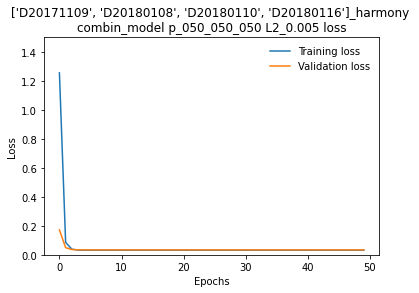

In [31]:
plt.title("{}_harmony \n{} p_{} L2_{} loss".format(train_list, model, dropout_rate, l2_weight))
plt.plot(train_loss_list,label='Training loss')
plt.plot(val_loss_list,label='Validation loss')
plt.ylim(0,1.5)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(frameon=False)
plt.savefig("../1.figure/{}_harmony/{}_harmony_{}_loss_p_{}_L2_{}.pdf".format(date, date, model, dropout_rate, l2_weight))

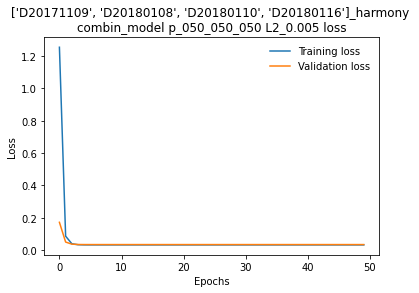

In [23]:
plt.title("{}_harmony \n{} p_{} L2_{} loss".format(train_list, model, dropout_rate, l2_weight))
plt.plot(train_loss_list,label='Training loss')
plt.plot(val_loss_list,label='Validation loss')
#plt.ylim(0,0.035)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(frameon=False)

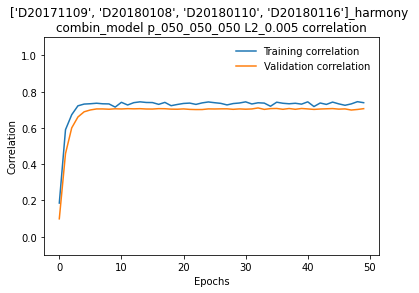

In [24]:
plt.title("{}_harmony \n{} p_{} L2_{} correlation".format(train_list, model, dropout_rate, l2_weight))
plt.plot(t_cor_list, label='Training correlation')
plt.plot(v_cor_list, label='Validation correlation')
plt.ylim(-0.1,1.1)
plt.xlabel('Epochs')
plt.ylabel('Correlation')
plt.legend(frameon=False)
plt.savefig("../1.figure/{}_harmony/{}_harmony_{}_{}_correlation_p_{}_L2_{}.pdf".format(date, date, model,
                                                                                train_list, dropout_rate, l2_weight))
plt.show()

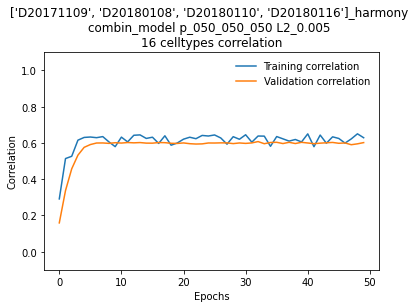

In [25]:
plt.title("{}_harmony \n{} p_{} L2_{} \n16 celltypes correlation".format(train_list, model, dropout_rate, l2_weight))
plt.plot(t_big_cor_list, label='Training correlation')
plt.plot(v_big_cor_list, label='Validation correlation')
plt.ylim(-0.1,1.1)
plt.xlabel('Epochs')
plt.ylabel('Correlation')
plt.legend(frameon=False)
plt.savefig("../1.figure/{}_harmony/{}_harmony_{}_{}_correlation_p_{}_L2_{}.pdf".format(date, date, model,
                                                                                train_list, dropout_rate, l2_weight))
plt.show()

In [26]:
rate = str(dropout_rate) +'_L2_'+ str(l2_weight)
r1 = np.quantile(train_loss_list,0.25)
r2 = np.quantile(cor_list,0.5)
r3 = np.quantile(val_cor_list,0.5)
r4 = np.quantile(t_big_cor_list,0.5)
r5 = np.quantile(v_big_cor_list,0.5)

data = {'Donor': [train_list],
        'Remove batch effect': 'harmony',
        'Model': [model],
        'Dropout rate': [rate],
        'Train loss (0.25)': [r1],
        'Train Correlation (0.5)': [r2],
        'Valid Correlation (0.5)': [r3],
        'Train Correlation (0.5) in 16 type': [r4],
        'Valid Correlation (0.5) in 16 type': [r5]
       }
df_1 = pd.DataFrame(data)

df_1

,Donor,Remove batch effect,Model,Dropout rate,Train loss (0.25),Train Correlation (0.5),Valid Correlation (0.5),Train Correlation (0.5) in 16 type,Valid Correlation (0.5) in 16 type
0,"[D20171109, D20180108, D20180110, D20180116]",harmony,combin_model,050_050_050_L2_0.005,0.0316,0.731013,0.702153,0.624896,0.59954


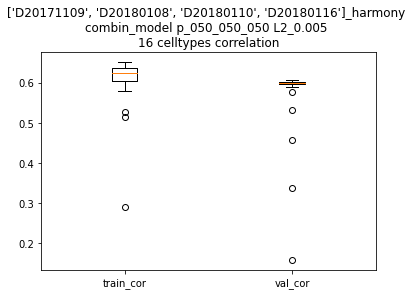

In [27]:
plt.title("{}_harmony \n{} p_{} L2_{} \n16 celltypes correlation".format(train_list, model, dropout_rate, l2_weight))
plt.boxplot([t_big_cor_list,v_big_cor_list])
plt.xticks([1,2], ["train_cor","val_cor"])
plt.show()

In [28]:
com_t_cor = t_big_cor_list
com_v_cor = v_big_cor_list